In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
# We will focus on homoscedastic mixture cases, or the case of a single cluster (so one covariance overall)

# Training process

This section evaluates the theoretical characterization of Result 1. As an illustration, we consider the first example of a Gaussian mixture with three clusters-

In [84]:
α=.3
β=.7 #fixed, single-time

In [153]:
K=3                                  #total number of Gaussians. 
weights=np.asarray([1/3, 1/3, 1/3])  #relative weights \pi of the different clusters
assert len(weights)==K
assert np.sum(weights)==1
r=2                                  #width of AE
N_samples=2000                       # for Monte-Carlo sampling
η=.1                                 #learning rate
regularization=.1/2           #weight decay

warm=0.1                             #not required, but we consider here an informed initialization along the centroids.

In [154]:
σ=np.tanh                            #activation function
dσ=lambda x:1-np.tanh(x)**2          #derivative of the activation function
 

In [155]:

N=1
Eigvals=np.ones(N)                   #We consider for simplicity cases where there is a finite number N of different eigenvalues,
Masses=np.ones(N)/N                  #Associated probabilities

section=int(d/N)
    
    


In [156]:
#initialization. To match the simulations, we match the initial values of the summary statistics m,q,t with the experimental values.
np.random.seed(42)
d=2000
w=np.zeros((r,d))
mus=np.zeros((K,d))
mus[0,:2]=[3,0]
mus[1,:2]=[0,-3]
mus[2, :2]=[-3,0]
    
w[:min(r,K),:]=mus[:min(r,K)]*warm*np.sqrt(d)

In [157]:
def init_mqt(): #initializes spectral densities

    m=np.array([[[mus[k,s*section:(s+1)*section]@w[j,s*section:(s+1)*section]for s in range(N)]for j in range(r) ] for k in range(K)])/np.sqrt(d)
    q=np.array([[[w[l,s*section:(s+1)*section]@w[j,s*section:(s+1)*section]for s in range(N)]for j in range(r) ] for l in range(r)])/d
    t=np.array([[[mus[k,s*section:(s+1)*section]@mus[u,s*section:(s+1)*section]for s in range(N)] for k in range(K)] for u in range(K)])        
    # m  is KxrxN
    #q is rxrxN
    # t is KxKxN
    return m,q,t

    

In [158]:
def construct_covariance(M,Q,Qc):
    #returns the total covariance used to draw samples for MC to evaluate the integrals
    Cov=np.zeros((K, 2*r,2*r))
    means=np.zeros((K, 2*r))
    for k in range(K):
        Cov[k, :r, :r]=Qc
        Cov[k, r:, r:]=Q
        means[:, :r]=M
    return Cov, means
        
    

In [159]:
def evolve_ODE(N_steps=1000, dt=0.01): #solves the system of coupled ODES
    M_list=[]   #summary statistic M
    Q_list=[]   #summary sraristic \mathcal{Q}
    Qc_list=[]  #summary statistic Q
    b_list=[]   #skip connection b
    T=[]        #parameter T


    m,q,t=init_mqt()
    b=0
    # m  is KxrxN
    #q is rxrxN
    # t is KxKxN
    M=np.einsum("ijk,k->ij", m,Masses)
    Q=np.einsum("ijk,k->ij", q,Masses)
    Qc=np.einsum("ijk,k->ij", q,Masses*Eigvals)

    
    T=np.einsum("ijk,k->ij", t,Masses)

    M_list.append(M)
    Q_list.append(Q)
    Qc_list.append(Qc)
    b_list.append(b)
    
    for i in range(N_steps):
        if i%100==0: print("Step {}/{}".format(i, N_steps))
       
        Cov, means=construct_covariance(M,Q,Qc)
        
        
        X=np.zeros((K,N_samples, 2*r))
        for k in range(K):

            X[k]=np.random.multivariate_normal(means[k], Cov[k], N_samples)   #X is of size K x N_samples x (r+r)
        
        dq=update_q(b,M,Q,Qc,T,m,q,t,X)
        dm=update_m(b,M,Q,Qc,T,m,q,t,X)
        db=update_b(b,M,Q,Qc,T,m,q,t,X)
     

        q=q+dq*dt
        m=m+dm*dt
        b+=db*dt
        
        

        M=np.einsum("ijk,k->ij", m,Masses)    # Kxr 
        Q=np.einsum("ijk,k->ij", q,Masses)    # rxr
        Qc=np.einsum("ijk,k->ij", q,Masses*Eigvals) # rxr

        M_list.append(M)
        Q_list.append(Q)
        Qc_list.append(Qc)
        b_list.append(b)
    M_list=np.array(M_list)
    Q_list=np.array(Q_list)
    Qc_list=np.array(Qc_list)
    b_list=np.array(b_list)
    return M_list,Q_list,Qc_list,b_list


        
        

In [160]:
def I(x, symbols, indices):
    # symbols represent the integrand, can be 1, 0, s, d, o for λ1, λ0, σ,σ', ω respectively
    #indices, list of the same size, gathers the corresponding indices
    order=len(symbols)
    result=np.ones(N_samples)
    for i in range(order):
        λ1=x[:,indices[i]]
        λ0=x[:,r+indices[i]]
        ω=α*λ0+β*λ1
        if symbols[i]=="1":
            result=result*λ1
        if symbols[i]=="0":
            result=result*λ0
        if symbols[i]=="o":
            result=result*ω
        if symbols[i]=="s":
            result=result*σ(ω)
        if symbols[i]=="d":
            result=result*dσ(ω)
    return np.mean(result)

In [161]:
def update_m_k(k,γ,b,M,Q,Qc,T,m,q,t,X):
    Is_γ=np.asarray([I(X[c],"s",[γ]) for c in range(K)])
    Iso_γ=np.asarray([I(X[c],"so",[γ,γ]) for c in range(K)])
    Idso_γ=np.asarray([I(X[c],"dso",[γ,γ,γ]) for c in range(K)])
    Ids_γ=np.asarray([I(X[c],"ds",[γ,γ]) for c in range(K)])
    I1do_γ=np.asarray([I(X[c],"1do",[γ,γ,γ]) for c in range(K)])
    I11d_γ=np.asarray([I(X[c],"11d",[γ,γ,γ]) for c in range(K)])
    I00d_γ=np.asarray([I(X[c],"00d",[γ,γ,γ]) for c in range(K)])
    I1d_γ=np.asarray([I(X[c],"1d",[γ,γ]) for c in range(K)])
    I0d_γ=np.asarray([I(X[c],"0d",[γ,γ]) for c in range(K)])
    I0do_γ=np.asarray([I(X[c],"0do",[γ,γ,γ]) for c in range(K)])

    Ω=β**2*Qc+α**2*Q
    

    #Summing all the terms that only depend on γ
    
    res=(1-b*β)*np.asarray([Is_γ[c]*t[c,k] for c in range(K)])   #size K x N
    #print((1-b*β))
    #print(np.einsum("ij, i->j", res,weights))
    
    res+=np.asarray([((1-b*β)*β*Eigvals-b*α**2)*m[k,γ,:]*(Iso_γ[c]-β*M[c,γ]*Is_γ[c]) for c in range(K)])/(Ω[γ,γ])   #size K x N
    
    res-=Q[γ,γ]/Ω[γ,γ]*np.asarray([(α**2+β**2*Eigvals)*m[k,γ,:]*(Idso_γ[c]-β*M[c,γ]*Ids_γ[c]) for c in range(K)])
    
    res+=α**2*(1-b*β)*Qc[γ,γ]/(Qc[γ,γ]*Ω[γ,γ]-β**2*Qc[γ,γ]**2)*np.asarray([m[k,γ,:]*(I1do_γ[c]-β*I11d_γ[c]) for c in range(K)])
    res-=α**2*b/(Q[γ,γ]*Ω[γ,γ]-α**2*Q[γ,γ]**2)*(Ω[γ,γ]-α**2*Q[γ,γ])*np.asarray([m[k,γ,:]*I00d_γ[c] for c in range(K)])
    res+=β*(1-b*β)*np.asarray([I1d_γ[c]*t[c,k] for c in range(K)])
    res+=β*(1-b*β)/(Qc[γ,γ]*Ω[γ,γ]-β**2*Qc[γ,γ]**2)*np.asarray([Eigvals*m[k,γ,:]*(I11d_γ[c]-M[c,γ]*I1d_γ[c]) for c in range(K)])*(Ω[γ,γ]-β**2*Qc[γ,γ])
    res-=α*β*b*np.asarray([I0d_γ[c]*t[c,k] for c in range(K)])
    res-=Q[γ,γ]*b*β*α**2/(Q[γ,γ]*Ω[γ,γ]-α**2*Q[γ,γ]**2)*np.asarray([Eigvals*m[k,γ,:]*(I0do_γ[c]-α*I00d_γ[c]-β*M[c,γ]*I0d_γ[c]) for c in range(K)])
    
    

    for δ in range(r):
        Iss=np.asarray([I(X[c],"ss",[γ,δ]) for c in range(K)])
        Idso_gd=np.asarray([I(X[c],"dso",[γ,δ,γ]) for c in range(K)])
        Idso_dg=np.asarray([I(X[c],"dso",[γ,δ,δ]) for c in range(K)])
        Ids=np.asarray([I(X[c],"ds",[γ,δ]) for c in range(K)])
        res-=np.asarray([Iss[c]*m[k,δ,:] for c in range(K)])
        
        if δ!=γ:
            res-=Q[γ,δ]/(Ω[γ,γ]*Ω[δ,δ]- Ω[δ,γ]**2)*np.asarray([(α**2+β**2*Eigvals)*(Idso_gd[c]-β*M[c,γ]*Ids[c])*(Ω[δ,δ]*m[k,γ,:]-Ω[γ,δ]*m[k,δ,:]) for c in range(K)])
            res-=Q[γ,δ]/(Ω[γ,γ]*Ω[δ,δ]- Ω[δ,γ]**2)*np.asarray([(α**2+β**2*Eigvals)*(Idso_dg[c]-β*M[c,δ]*Ids[c])*(Ω[γ,γ]*m[k,δ,:]-Ω[γ,δ]*m[k,γ,:]) for c in range(K)])
        res-=β*Q[γ,δ]*np.asarray([t[c,k,:]*Ids[c] for c in range(K)])
    res=np.einsum("ij, i->j", res,weights)  #res is now size N
    res-=regularization*m[k,γ,:]
    return res


def update_m(b,M,Q,Qc,T,m,q,t,X):
    result=np.zeros(m.shape)  #KxrxN
    for k in range(K):
        for γ in range(r):
            result[k,γ]= update_m_k(k,γ,b,M,Q,Qc,T,m,q,t,X)
    return result
            

In [162]:
def update_q1(γ,δ,b,M,Q,Qc,T,m,q,t,X):
    #the linear part involves the same integrals as m. To combine !
    Is_γ=np.asarray([I(X[c],"s",[γ]) for c in range(K)])
    Iso_γ=np.asarray([I(X[c],"so",[γ,γ]) for c in range(K)])
    Idso_γ=np.asarray([I(X[c],"dso",[γ,γ,γ]) for c in range(K)])
    Ids_γ=np.asarray([I(X[c],"ds",[γ,γ]) for c in range(K)])
    I1do_γ=np.asarray([I(X[c],"1do",[γ,γ,γ]) for c in range(K)])
    I11d_γ=np.asarray([I(X[c],"11d",[γ,γ,γ]) for c in range(K)])
    I00d_γ=np.asarray([I(X[c],"00d",[γ,γ,γ]) for c in range(K)])
    I1d_γ=np.asarray([I(X[c],"1d",[γ,γ]) for c in range(K)])
    I0d_γ=np.asarray([I(X[c],"0d",[γ,γ]) for c in range(K)])
    I0do_γ=np.asarray([I(X[c],"0do",[γ,γ,γ]) for c in range(K)])

    Ω=β**2*Qc+α**2*Q

    #linear part
    res=(1-b*β)*np.asarray([Is_γ[c]*m[c,δ,:] for c in range(K)])   #size K x N
    res+=np.asarray([((1-b*β)*β*Eigvals-b*α**2)*q[γ,δ,:]*(Iso_γ[c]-β*M[c,γ]*Is_γ[c]) for c in range(K)])/(Ω[γ,γ])   #size K x N
    res-=Q[γ,γ]/Ω[γ,γ]*np.asarray([(α**2+β**2*Eigvals)*q[γ,δ,:]*(Idso_γ[c]-β*M[c,γ]*Ids_γ[c]) for c in range(K)])
    res+=α**2*(1-b*β)*Qc[γ,γ]/(Qc[γ,γ]*Ω[γ,γ]-β**2*Qc[γ,γ]**2)*np.asarray([q[γ,δ,:]*(I1do_γ[c]-β*I11d_γ[c]) for c in range(K)])
    res-=α**2*b/(Q[γ,γ]*Ω[γ,γ]-α**2*Q[γ,γ]**2)*(Ω[γ,γ]-α**2*Q[γ,γ])*np.asarray([q[γ,δ,:]*I00d_γ[c] for c in range(K)])
    res+=β*(1-b*β)*np.asarray([I1d_γ[c]*m[c,δ,:] for c in range(K)])
    res+=β*(1-b*β)/(Qc[γ,γ]*Ω[γ,γ]-β**2*Qc[γ,γ]**2)*np.asarray([Eigvals*q[γ,δ,:]*(I11d_γ[c]-M[c,γ]*I1d_γ[c]) for c in range(K)])*(Ω[γ,γ]-β**2*Qc[γ,γ])
    res-=α*β*b*np.asarray([I0d_γ[c]*m[c,δ,:] for c in range(K)])
    res-=Q[γ,γ]*b*β*α**2/(Q[γ,γ]*Ω[γ,γ]-α**2*Q[γ,γ]**2)*np.asarray([Eigvals*q[γ,δ,:]*(I0do_γ[c]-α*I00d_γ[c]-β*M[c,γ]*I0d_γ[c]) for c in range(K)])

    

    for ϵ in range(r):
        Iss=np.asarray([I(X[c],"ss",[γ,ϵ]) for c in range(K)])
        Idso_gd=np.asarray([I(X[c],"dso",[γ,ϵ,γ]) for c in range(K)])
        Idso_dg=np.asarray([I(X[c],"dso",[γ,ϵ,ϵ]) for c in range(K)])
        Ids=np.asarray([I(X[c],"ds",[γ,ϵ]) for c in range(K)])
        
        res-=np.asarray([Iss[c]*q[δ,ϵ,:] for c in range(K)])
        if ϵ!=γ:
            res-=Q[γ,ϵ]/(Ω[γ,γ]*Ω[ϵ,ϵ]- Ω[ϵ,γ]**2)*np.asarray([(α**2+β**2*Eigvals)*(Idso_gd[c]-β*M[c,γ]*Ids[c])*(Ω[ϵ,ϵ]*q[γ,δ,:]-Ω[γ,ϵ]*q[ϵ,δ,:]) for c in range(K)])
            res-=Q[γ,ϵ]/(Ω[γ,γ]*Ω[ϵ,ϵ]- Ω[ϵ,γ]**2)*np.asarray([(α**2+β**2*Eigvals)*(Idso_dg[c]-β*M[c,ϵ]*Ids[c])*(Ω[γ,γ]*q[δ,ϵ,:]-Ω[γ,ϵ]*q[γ,δ,:]) for c in range(K)])
        res-=β*Q[ϵ,γ]*np.asarray([m[c,δ,:]*Ids[c] for c in range(K)])
    res=np.einsum("ij, i->j", res,weights)  #res is now size N
    res-=regularization*q[γ,δ,:]
    return res

def update_q2(γ,δ,b,M,Q,Qc,T,m,q,t,X):
    Iss=np.asarray([I(X[c],"ss",[γ,δ]) for c in range(K)])
    Isd1=np.asarray([I(X[c],"sd1",[γ,δ,δ]) for c in range(K)])
    Isd0=np.asarray([I(X[c],"sd0",[γ,δ,δ]) for c in range(K)])
    Idd11=np.asarray([I(X[c],"dd11",[γ,δ,γ,δ]) for c in range(K)])
    Idd01=np.asarray([I(X[c],"dd01",[γ,δ,γ,δ]) for c in range(K)])
    Idd01_2=np.asarray([I(X[c],"dd01",[γ,δ,δ,γ]) for c in range(K)])
    Idd00=np.asarray([I(X[c],"dd00",[γ,δ,γ,δ]) for c in range(K)])

    #first, we sum all terms only involving the γ,δ indices
    res=.5*np.asarray([Masses*Iss[c]*((1-b*β)**2*Eigvals+b**2*α**2) for c in range(K)])
    res+=np.asarray([Masses*((1-b*β)*Isd1[c]-b*α*Isd0[c])*(β*(1-b*β)*Eigvals-b*α**2) for c in range(K)])
    res+=.5*(1-b*β)**2*np.asarray([Idd11[c]*Masses*(β**2*Eigvals+α**2) for c in range(K)])
    res-=.5*(1-b*β)**b*α*np.asarray([(Idd01[c]+Idd01_2[c])*Masses*(β**2*Eigvals+α**2) for c in range(K)])
    res+=.5*(b*α)**2*np.asarray([Idd00[c]*Masses*(β**2*Eigvals+α**2) for c in range(K)])

    for ϵ in range(r):
        Issd=np.asarray([I(X[c],"ssd",[γ,ϵ,δ]) for c in range(K)])
        Idsd1=np.asarray([I(X[c],"dsd1",[γ,ϵ,δ,δ]) for c in range(K)])
        Idsd0=np.asarray([I(X[c],"dsd0",[γ,ϵ,δ,δ]) for c in range(K)])

        res-=Q[ϵ,δ]*np.asarray([Masses*Issd[c]*(β*(1-b*β)*Eigvals-b*α**2) for c in range(K)])
        res-=Q[ϵ,γ]*np.asarray([Masses*((1-b*β)*Idsd1[c]-b*α*Idsd0[c])*(β**2*Eigvals+α**2) for c in range(K)])

        for ι in range(r):
            Idsds=np.asarray([I(X[c],"dsds",[γ,ϵ,δ,ι]) for c in range(K)])
            res+=.5*np.asarray([Idsds[c]*(β**2*Eigvals+α**2)*Masses for c in range(K)])*Q[γ,ϵ]*Q[δ,ι]

    res=np.einsum("ij, i->j", res,weights)
    return res


def update_q(b,M,Q,Qc,T,m,q,t,X):
    res=np.zeros(q.shape)  #KxrxN
    for δ in range(r):
        for γ in range(r):
            res[γ,δ]= update_q1(γ,δ,b,M,Q,Qc,T,m,q,t,X) +update_q2(γ,δ,b,M,Q,Qc,T,m,q,t,X)*2*η
        
    res_old=res.copy()
    for δ in range(r):
        for γ in range(r):
            res[γ,δ]=res_old[γ,δ]+res_old[δ,γ]
    return res



    


In [163]:
def update_b(b,M,Q,Qc,T,m,q,t,X):
    return β*(1-b*β)*np.mean(Eigvals)-b*α**2

In [164]:
N_steps=400       #number of steps in the discretization
dt=0.01           #step size 
#Note that the total training time \tau is thus equal to N_steps x dt

In [165]:
M,Q,Qc,b=evolve_ODE(N_steps=N_steps, dt=dt)

Step 0/400
Step 100/400
Step 200/400
Step 300/400


Text(0.5, 0, '$\\vartheta$')

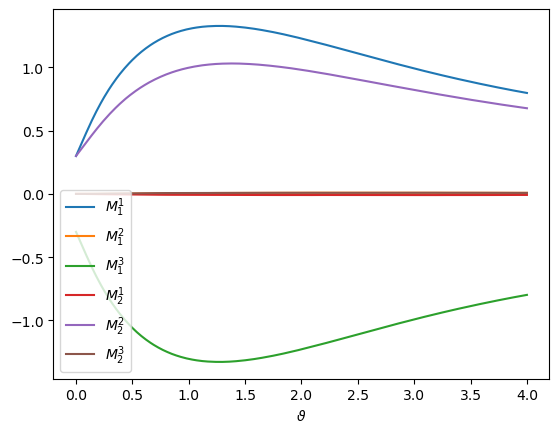

In [149]:

plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,0,0]/3, label=r"$M^1_{1}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,1,0]/3, label=r"$M^2_{1}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,2,0]/3, label=r"$M^3_{1}$")

plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,0,1]/3, label=r"$M^1_{2}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,1,1]/3, label=r"$M^2_{2}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,2,1]/3, label=r"$M^3_{2}$")
plt.legend(loc=3)
plt.xlabel(r"$\vartheta$")



Text(0.5, 0, '$\\vartheta$')

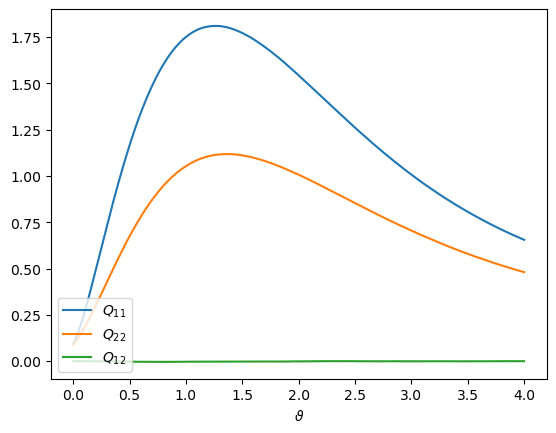

In [150]:
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,0,0],  label=r"$Q_{11}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,1,1],  label=r"$Q_{22}$")
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,0,1],  label=r"$Q_{12}$")
plt.legend(loc=3)
plt.xlabel(r"$\vartheta$")


Text(0.5, 0, '$\\vartheta$')

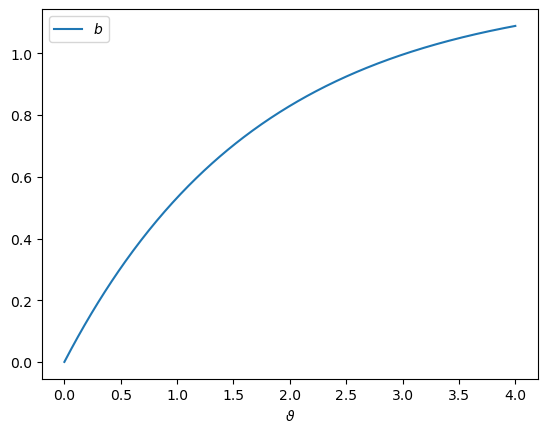

In [133]:
plt.plot(np.linspace(0,N_steps,N_steps+1)*dt, b, label=r"$b$")
plt.legend(loc=2)
plt.xlabel(r"$\vartheta$")

In [151]:
M_simu=np.load("Data/M_simu.npy")
Q_simu=np.load("Data/Q_simu.npy")
b_simu=np.load("Data/b_simu.npy")
T=len(M_simu)
ts=np.linspace(0,T,T)/T*N_steps*dt

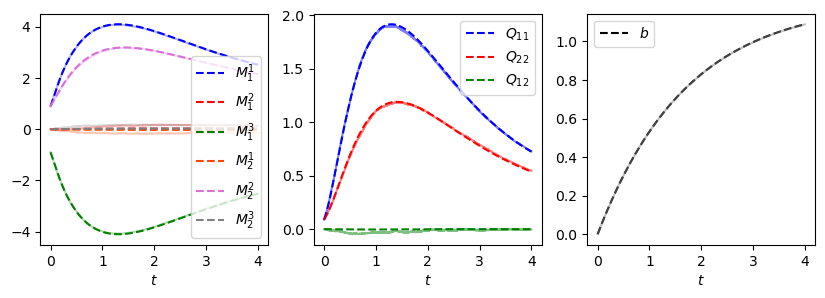

In [166]:
fig, axs=plt.subplots(1,3, figsize=(10,3))
ax=axs.flatten()
ax[0].plot(ts, M_simu[:,0,0],alpha=.3, c="b")
ax[0].plot(ts, M_simu[:,0,1],alpha=.3, c="r")
ax[0].plot(ts, M_simu[:,0,2],alpha=.3, c="g")
ax[0].plot(ts, M_simu[:,1,0],alpha=.3, c="orangered")
ax[0].plot(ts, M_simu[:,1,1], alpha=.3, c="orchid")
ax[0].plot(ts, M_simu[:,1,2],alpha=.3, c="grey")

ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,0,0], label=r"$M^1_1$", ls="--", c="b")
ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,1,0], label=r"$M^2_1$", ls="--", c="r")
ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,2,0], label=r"$M^3_1$", ls="--", c="g")

ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,0,1], label=r"$M^1_2$", ls="--", c="orangered")
ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,1,1], label=r"$M^2_2$", ls="--", c="orchid")
ax[0].plot(np.linspace(0,N_steps,N_steps+1)*dt, M[:,2,1], label=r"$M^3_2$", ls="--", c="grey")

ax[0].legend(loc=4)

ax[1].plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,0,0], ls="--", label=r"$Q_{11}$", c="b")
ax[1].plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,1,1], ls="--", label=r"$Q_{22}$", c="r")
ax[1].plot(np.linspace(0,N_steps,N_steps+1)*dt, Q[:,0,1], ls="--", label=r"$Q_{12}$", c="g")

ax[1].plot(np.linspace(0, N_steps*dt, len(Q_simu)), Q_simu[:,0,0],alpha=0.5, c="b")
ax[1].plot(np.linspace(0, N_steps*dt, len(Q_simu)), Q_simu[:,1,1],alpha=0.5, c="r")
ax[1].plot(np.linspace(0, N_steps*dt, len(Q_simu)), Q_simu[:,0,1],alpha=0.5, c="g")

ax[1].legend()

ax[2].plot(np.linspace(0,N_steps,N_steps+1)*dt, b, label=r"$b$".format(2,0), ls="--", c="black")
ax[2].plot(np.linspace(0, N_steps*dt, len(b_simu)), b_simu, c="grey",alpha=0.5)

for a in ax:
    a.set_xlabel(r"$t$")

ax[2].legend()


# Sampling 

In [167]:
τ=-1   #training time
M=M[τ]
Q=Q[τ]
b=b[τ]

In [168]:
def Γ(t):
    return 1+t/(1-t)

def Δ(t):
    return b*(1+t/(1-t))-1/(1-t)

In [170]:
T_gen=100       #number of discretization steps
dt=1/T_gen     #step size
N=4000         #number of samples to be generated

#initialization
Z=np.random.multivariate_normal(mean=np.zeros(r), cov=Q,size=N)


for k in range(T_gen-1):
    t=k/T_gen
    Z_new=(1+dt*Δ(t))*Z+Γ(t)*np.tanh(Z)@Q.T*dt
    Z=Z_new.copy()


In [171]:
Qinv=np.linalg.pinv(Q)
G=M[:2]/3  #in this case, the reference subspace is spanned by the centroids, so G and M coincide


In [172]:
#computing variance of the Gaussian term
Var=1
for k in range(T_gen):
    t=k/T_gen
    Var*=np.exp(Δ(t)*dt)   
ϵ=1e-4

#Projecting in \mathcal{E}
in_space=G@Qinv@Z.T
cov=Var*(np.eye(G.shape[0])*(1+ϵ)-G@Qinv@G.T)
Gaussian=np.random.multivariate_normal(mean=np.zeros(G.shape[0]), cov=cov, size=N)

Projections=in_space.T+Gaussian

In [175]:
X_trans=np.load("Data/Samples_simus.npy")[:,:2]

<Axes: >

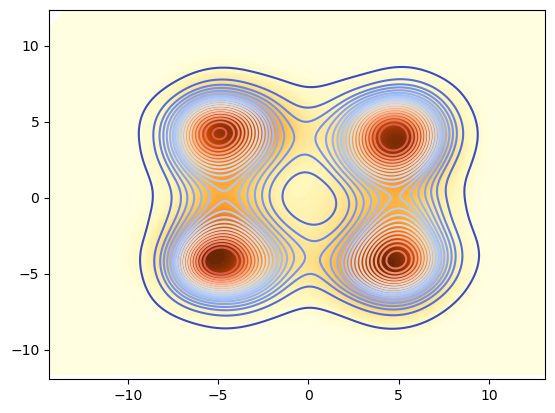

In [176]:
sns.kdeplot(x=Projections[:,0],y=Projections[:,1], fill=False, thresh=0.02, levels=20, cmap="coolwarm", label=r"$\hat{\rho}$ (theory)")
sns.kdeplot(x=X_trans[:,0],y=X_trans[:,1], fill=True, thresh=0.0, levels=100, cmap="YlOrBr")